In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import math
import imutils
import pandas as pd

**Table of contents**<a id='toc0_'></a>    
- [<span style="color:orange">*Image Preprocessing*</span>](#toc1_1_)    
  - [<span style="color:#AF7AC5">Import Image</span>](#toc1_1_1_)    
  - [<span style="color:#AF7AC5">Iris Localization</span>](#toc1_1_2_)    
    - [Houghman Circle Detection](#toc1_1_2_1_)    
      - [Find Pupil `Slow`](#toc1_1_2_1_1_)    
      - [Find Pupil `Fast`](#toc1_1_2_1_2_)    
    - [Localization](#toc1_1_2_2_)    
      - [Houghman circle with Active contour](#toc1_1_2_2_1_)    
      - [Only Active contour](#toc1_1_2_2_2_)    
      - [AI Generated Active Contours](#toc1_1_2_2_3_)    
  - [<span style="color:#AF7AC5">Iris Normalization</span>](#toc1_1_3_)    
    - [Circle Function](#toc1_1_3_1_)    
    - [Houghman Circle with Active Contour](#toc1_1_3_2_)    
    - [Active Contour Only](#toc1_1_3_3_)    
  - [<span style="color:#AF7AC5">Eye Lash Removal</span>](#toc1_1_4_)    
- [<span style="color:orange">*Feature Extraction*</span>](#toc1_2_)    
  - [<span style="color:#AF7AC5">Convolute with Gabor</span>](#toc1_2_1_)    
- [<span style="color:orange">*Matching*</span>](#toc1_3_)    
  - [<span style="color:#AF7AC5">Shift Bit Function</span>](#toc1_3_1_)    
  - [<span style="color:#AF7AC5">Hamming Distance</span>](#toc1_3_2_)    
- [<span style="color:orange">*Test Plot*</span>](#toc1_4_)    
  - [<span style="color:#AF7AC5">All Image Check</span>](#toc1_4_1_)    
  - [<span style="color:#AF7AC5">Matching Check</span>](#toc1_4_2_)    
- [<span style="color:orange">*Main Program*</span>](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[<span style="color:orange">*Image Preprocessing*</span>](#toc0_)

### <a id='toc1_1_1_'></a>[<span style="color:#AF7AC5">Import Image</span>](#toc0_)

In [2]:
def read_image(path):
    img = cv2.imread(path)
    gray_eye_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_eye_image

### <a id='toc1_1_2_'></a>[<span style="color:#AF7AC5">Iris Localization</span>](#toc0_)

#### <a id='toc1_1_2_1_'></a>[Houghman Circle Detection](#toc0_)

##### <a id='toc1_1_2_1_1_'></a>[Find Pupil `Slow`](#toc0_)

In [3]:
def get_edges(image):
        edges = cv2.Canny(image, 20, 100)
        kernel = np.ones((3, 3), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=2)
        # ksize = 2 * random.randrange(5, 11) + 1
        edges = cv2.GaussianBlur(edges, (15, 15), 0)
        return edges

In [4]:
def find_pupil(img):
    param1 = 200  # 200
    param2 = 120  # 150
    pupil_circles = []
    while(param2 > 35 and len(pupil_circles) < 100):
        for mdn, thrs in [(m, t)
                          for m in [3, 5, 7]
                          for t in [20, 25, 30, 35, 40, 45, 50, 55, 60]]:
            # Median Blur
            median = cv2.medianBlur(img, 2*mdn+1)

            # Threshold
            _, thres = cv2.threshold(
                median, thrs, 255,
                cv2.THRESH_BINARY_INV)

            # Canny Edges
            edges = get_edges(thres)

            # HoughCircles
            circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 1,
                                       np.array([]), param1, param2)
            if circles is not None:
                # convert the (x, y) coordinates and radius of the circles
                # to integers
                circles = np.round(circles).astype("int")
                for c in circles:
                    pupil_circles.append(c)

        param2 = param2 - 10

    cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    if circles is None:
        return
    mean_0 = int(np.mean([c[0][0] for c in circles]))
    mean_1 = int(np.mean([c[0][1] for c in circles]))
    mean_2 = int(np.mean([c[0][2] for c in circles]))

    return mean_0, mean_1, mean_2


##### <a id='toc1_1_2_1_2_'></a>[Find Pupil `Fast`](#toc0_)

In [5]:
def find_pupil_new(img):
    img = cv2.medianBlur(img, 15)
    img = cv2.Canny(img, 0, 50)
    param1 = 200  # 200
    param2 = 120  # 150
    circles = None
    while circles is None and param2 > 20:
        # HoughCircles
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 1,
                                    param1=param1, param2=param2,
                                    minRadius=20, maxRadius=60)

        param2 -= 1
    
    if circles is None:
        return None, None, None

    return circles.astype(int)[0][0]

#### <a id='toc1_1_2_2_'></a>[Localization](#toc0_)

##### <a id='toc1_1_2_2_1_'></a>[Houghman circle with Active contour](#toc0_)

|`alpha`|`beta`|`gamma`|
|---|---|---|
|1.6|390|0.005|
|1.5|390|0.005|
|1.6|300|0.05|
|1.6|500|0.05|
|1.6|1000|0.05|
|1.45|590|0.01|

In [6]:
def localization(img, N=400):
    DoG = cv2.GaussianBlur(img, (3, 3), 0) - cv2.GaussianBlur(img, (25, 25), 0)
    median1 = cv2.medianBlur(DoG, 9)
    eroted = cv2.erode(median1, np.ones((3, 3), np.uint8), iterations=1)
    median2 = cv2.medianBlur(eroted, 5)
    dilated = cv2.dilate(median2, np.ones((3, 3), np.uint8), iterations=1)
    eroted = cv2.erode(dilated, np.ones((5, 5), np.uint8), iterations=1)
    result = cv2.bitwise_or(img, eroted)
        
    x, y, rad = find_pupil_new(img)
    
    if x is None:
        x, y = 350, 250
    
    s = np.linspace(0, 2*np.pi, 400)
    c = x + 150*np.cos(s)
    r = y + 150*np.sin(s)
    init = np.array([r, c]).T

    snake = active_contour(result, init, alpha=1.45, beta=590, w_line=0.01, gamma=0.01)
    
    return init, snake, (x, y, rad)
    

##### <a id='toc1_1_2_2_2_'></a>[Only Active contour](#toc0_)

In [7]:
def localization_active(img, N=400):
    DoG = cv2.GaussianBlur(img, (3, 3), 0) - cv2.GaussianBlur(img, (25, 25), 0)
    median1 = cv2.medianBlur(DoG, 9)
    eroted = cv2.erode(median1, np.ones((3, 3), np.uint8), iterations=1)
    median2 = cv2.medianBlur(eroted, 5)
    dilated = cv2.dilate(median2, np.ones((3, 3), np.uint8), iterations=1)
    eroted = cv2.erode(dilated, np.ones((5, 5), np.uint8), iterations=1)
    result = cv2.bitwise_or(img, eroted)
        
    s = np.linspace(0, 2*np.pi, 400)
    c = 350 + 200*np.cos(s)
    r = 250 + 200*np.sin(s)

    init = np.array([r, c]).T
    
    temp = cv2.medianBlur(img, 15)
    temp = cv2.Canny(temp, 0, 20)

    snake_pupil = active_contour(result, init, alpha=4, beta=1000, gamma=0.05)
    
    s = np.linspace(0, 2*np.pi, 400)
    c = 350 + 250*np.cos(s)
    r = 250 + 250*np.sin(s)
    init = np.array([r, c]).T

    snake = active_contour(result, init, alpha=1.45, beta=590, gamma=0.05)
    
    return init, snake, snake_pupil

##### <a id='toc1_1_2_2_3_'></a>[AI Generated Active Contours](#toc0_)

In [8]:
def localize_iris(iris_img):
  # Convert the image to grayscale
  gray_iris = cv2.cvtColor(iris_img, cv2.COLOR_BGR2GRAY)

  # Apply a Gaussian blur to the image to reduce noise
  blurred_iris = cv2.GaussianBlur(gray_iris, (5, 5), 0)

  # Use the Canny edge detector to find edges in the image
  edges = cv2.Canny(blurred_iris, 50, 150)

  # Use the active contour algorithm (e.g. Snake) to find the iris boundary
  contours = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)
  contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
  iris_boundary = cv2.approxPolyDP(contours[0], 0.01 * cv2.arcLength(contours[0], True), True)

  # Use the iris boundary to crop the iris region from the image
  mask = np.zeros(edges.shape, dtype=np.uint8)
  cv2.drawContours(mask, [iris_boundary], -1, 255, -1)
  cropped_iris = cv2.bitwise_and(iris_img, iris_img, mask=mask)

  # Return the resulting cropped iris image
  return cropped_iris

### <a id='toc1_1_3_'></a>[<span style="color:#AF7AC5">Iris Normalization</span>](#toc0_)

#### <a id='toc1_1_3_1_'></a>[Circle Function](#toc0_)

In [9]:
def trans_axis(circle, theta):

    x0, y0, r = circle
    x = int(x0 + r * math.cos(theta))
    y = int(y0 + r * math.sin(theta))
    return x, y

#### <a id='toc1_1_3_2_'></a>[Houghman Circle with Active Contour](#toc0_)

In [10]:
def normalization(img, pupil_circle, iris_circle, M=64, N=400, offset=0):

    normalized = np.zeros((M, N))
    theta = np.linspace(0, 2 * np.pi, N)

    for i in range(N):
        curr_theta = theta[i] + offset
        if curr_theta > 2 * np.pi:
            curr_theta -= 2 * np.pi
        begin = trans_axis(pupil_circle, curr_theta)
        end = iris_circle

        xspace = np.linspace(begin[0], end[i][0], M)
        yspace = np.linspace(begin[1], end[i][1], M)
        normalized[:, i] = [255 - img[int(y), int(x)]
                            if 0 <= int(x) < img.shape[1] and 0 <= int(y) < img.shape[0]
                            else 0
                            for x, y in zip(xspace, yspace)]
    return normalized

#### <a id='toc1_1_3_3_'></a>[Active Contour Only](#toc0_)

In [11]:
def normalization_active(img, pupil_circle, iris_circle, M=64, N=400, offset=0):

    normalized = np.zeros((M, N))
    theta = np.linspace(0, 2 * np.pi, N)

    for i in range(N):
        curr_theta = theta[i] + offset
        if curr_theta > 2 * np.pi:
            curr_theta -= 2 * np.pi
        begin = pupil_circle
        end = iris_circle

        xspace = np.linspace(begin[i][0], end[i][0], M)
        yspace = np.linspace(begin[i][1], end[i][1], M)
        normalized[:, i] = [255 - img[int(y), int(x)]
                            if 0 <= int(x) < img.shape[1] and 0 <= int(y) < img.shape[0]
                            else 0
                            for x, y in zip(xspace, yspace)]
    return normalized

### <a id='toc1_1_4_'></a>[<span style="color:#AF7AC5">Eye Lash Removal</span>](#toc0_)

In [12]:
def lash_removal(img, thresh=40):
    ref = img < thresh
    coords = np.where(ref == 1)
    rmov_img = img.astype(float)
    rmov_img[coords] = float('nan')
    return rmov_img

In [13]:
def lash_removal_daugman(img, thresh=40):
    ref = img < thresh
    coords = np.where(ref == 1)
    rmov_img = img.astype(float)
    rmov_img[coords] = float('nan')
    temp_img = rmov_img.copy()
    temp_img[coords] = 255/2
    avg = np.sum(temp_img) / (rmov_img.shape[0] * rmov_img.shape[1])
    rmov_img[coords] = avg
    
    noise_img = np.zeros(img.shape)
    noise_img[coords] = 1
    return rmov_img, noise_img.astype(bool)

## <a id='toc1_2_'></a>[<span style="color:orange">*Feature Extraction*</span>](#toc0_)

### <a id='toc1_2_1_'></a>[<span style="color:#AF7AC5">Convolute with Gabor</span>](#toc0_)

In [14]:
def gaborconvolve_f(img, minw_length, mult, sigma_f):
    """
    Convolve each row of an imgage with 1D log-Gabor filters.
    """
    rows, ndata = img.shape
    logGabor_f = np.zeros(ndata)
    filterb = np.zeros([rows, ndata], dtype=complex)

    radius = np.arange(ndata/2 + 1) / (ndata/2) / 2
    radius[0] = 1

    # filter wavelength
    wavelength = minw_length

    # radial filter component 
    fo = 1 / wavelength
    logGabor_f[0: int(ndata/2) + 1] = np.exp((-(np.log(radius/fo))**2) /
                                    (2 * np.log(sigma_f)**2))
    logGabor_f[0] = 0

    # convolution for each row
    for r in range(rows):
        signal = img[r, 0:ndata]
        imagefft = np.fft.fft(signal)
        filterb[r, :] = np.fft.ifft(imagefft * logGabor_f)
    
    return filterb

In [15]:
def encode_iris(arr_polar, arr_noise, minw_length, mult, sigma_f):
    """
    Generate iris template and noise mask from the normalised iris region.
    """
    # convolve with gabor filters
    filterb = gaborconvolve_f(arr_polar, minw_length, mult, sigma_f)
    l = arr_polar.shape[1]
    template = np.zeros([arr_polar.shape[0], 2 * l])
    h = np.arange(arr_polar.shape[0])

    # making the iris template
    mask_noise = np.zeros(template.shape)
    filt = filterb[:, :]

    # quantization and check to se if the phase data is useful
    H1 = np.real(filt) > 0
    H2 = np.imag(filt) > 0

    H3 = np.abs(filt) < 0.0001
    for i in range(l):
        ja = 2 * i

        # biometric template
        template[:, ja] = H1[:, i]
        template[:, ja + 1] = H2[:, i]
        # noise mask_noise
        mask_noise[:, ja] = arr_noise[:, i] | H3[:, i]
        mask_noise[:, ja + 1] = arr_noise[:, i] | H3[:, i]

    return template, mask_noise

## <a id='toc1_3_'></a>[<span style="color:orange">*Matching*</span>](#toc0_)

### <a id='toc1_3_1_'></a>[<span style="color:#AF7AC5">Shift Bit Function</span>](#toc0_)

In [16]:
def shiftbits_ham(template, noshifts):
    templatenew = np.zeros(template.shape)
    width = template.shape[1]
    s = 2 * np.abs(noshifts)
    p = width - s

    if noshifts == 0:
        templatenew = template

    elif noshifts < 0:
        x = np.arange(p)
        templatenew[:, x] = template[:, s + x]
        x = np.arange(p, width)
        templatenew[:, x] = template[:, x - p]

    else:
        x = np.arange(s, width)
        templatenew[:, x] = template[:, x - s]
        x = np.arange(s)
        templatenew[:, x] = template[:, p + x]

    return templatenew

### <a id='toc1_3_2_'></a>[<span style="color:#AF7AC5">Hamming Distance</span>](#toc0_)

In [17]:
def HammingDistance(template1, mask1, template2, mask2):
    hd = np.nan

    # Shifting template left and right, use the lowest Hamming distance
    for shifts in range(-8, 9):
        template1s = shiftbits_ham(template1, shifts)
        mask1s = shiftbits_ham(mask1, shifts)

        mask = np.logical_and(mask1s, mask2)
        nummaskbits = np.sum(mask == 1)
        totalbits = template1s.size - nummaskbits

        C = np.logical_xor(template1s, template2)
        C = np.logical_and(C, np.logical_not(mask))
        bitsdiff = np.sum(C == 1)

        if totalbits == 0:
            hd = np.nan
        else:
            hd1 = bitsdiff / totalbits
            if hd1 > hd or np.isnan(hd):
                hd = hd1

    return hd

## <a id='toc1_4_'></a>[<span style="color:orange">*Test Plot*</span>](#toc0_)

### <a id='toc1_4_1_'></a>[<span style="color:#AF7AC5">All Image Check</span>](#toc0_)

In [18]:
def plot_prepro(img_num1=0, img_num2=60, plot_cols=3):
    plot_size = 29
    plot_rows = math.ceil((img_num2-img_num1) / plot_cols)

    # fig, ax = plt.subplots(plot_rows*2, plot_cols, figsize=(20, plot_size*plot_rows))
    fig = plt.figure(figsize=(20, plot_size*plot_rows), constrained_layout=False)
    outer_grid = fig.add_gridspec(plot_rows*2, plot_cols, wspace=0.1, hspace=-0.2)

    for i in range(img_num1, img_num2):
        # Read image
        img = read_image(f'CASIA-IrisV2/device1/00{str(i).zfill(2)}/00{str(i).zfill(2)}_000.bmp')
        
        # Image Preprocessing (Localization)
        init, snake, circles = localization(img)
        
        pupil_circle = circles
        iris_circle = np.flip(np.array(snake).astype(int), 1)
        
        # Graph of Localization
        x = i//plot_cols
        y = i-(i//plot_cols)*plot_cols
        
        inner_grid = outer_grid[x, y].subgridspec(5, 1, hspace=-0.75)
        ax0 = fig.add_subplot(inner_grid[0:2])
        ax1 = fig.add_subplot(inner_grid[3])
        ax2 = fig.add_subplot(inner_grid[4])
        
        ax0.imshow(img, cmap='gray')
        ax0.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
        ax0.set_title(f'Image {i}')
        
        if circles[2] is None:
            print(f"No circles found in image {i}")
            ax1.imshow(img, cmap='gray')
            ax1.axis([0, 400, 64, 0])
            continue
        
        circle = plt.Circle((circles[0], circles[1]), circles[2], color='g', fill=False, linewidth=1)
        ax0.add_patch(circle)
        ax0.scatter(circles[0], circles[1], s=20, c='g', marker='o')
        
        # Image Preprocessing (Normalization)
        # With eyelashes removal
        iris_norm = normalization(img, pupil_circle, iris_circle)
        
        # Without eyelashes removal
        # iris_norm = normalization(img, pupil_circle, iris_circle)
        
        ax1.imshow(iris_norm, cmap='gray')
        ax1.set_title(f'Normalized Image {i}')
        
        # Feature Extraction
        romv_img, noise_img = lash_removal_daugman(iris_norm, thresh=50)
        template, mask_noise = encode_iris(romv_img, noise_img, minw_length=18, mult=1, sigma_f=0.5)
        
        ax2.imshow(template, cmap='gray')
        ax2.set_title(f'Binary Encoded Image {i}')
        
    plt.show()

### <a id='toc1_4_2_'></a>[<span style="color:#AF7AC5">Matching Check</span>](#toc0_)

In [21]:
def plot_matching(img_num, compare_num=10):
    plot_size = 29
    plot_cols = 2
    plot_rows = math.ceil((compare_num) / plot_cols)
    templates = []
    masks = []

    # fig, ax = plt.subplots(plot_rows*2, plot_cols, figsize=(20, plot_size*plot_rows))
    fig = plt.figure(figsize=(20, plot_size*plot_rows), constrained_layout=False)
    outer_grid = fig.add_gridspec(plot_rows*2, plot_cols, wspace=0.1, hspace=-0.2)

    for i in range(compare_num):
        # Read image
        img = read_image(f'CASIA-IrisV2/device1/00{str(img_num).zfill(2)}/00{str(img_num).zfill(2)}_0{str(i).zfill(2)}.bmp')
        
        # Image Preprocessing (Localization)
        init, snake, circles = localization(img)
        
        pupil_circle = circles
        iris_circle = np.flip(np.array(snake).astype(int), 1)
        
        # Graph of Localization
        x = i//plot_cols
        y = i-(i//plot_cols)*plot_cols
        
        inner_grid = outer_grid[x, y].subgridspec(5, 1, hspace=-0.7)
        ax0 = fig.add_subplot(inner_grid[0:2])
        ax1 = fig.add_subplot(inner_grid[3])
        ax2 = fig.add_subplot(inner_grid[4])
        
        ax0.imshow(img, cmap='gray')
        ax0.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
        ax0.set_title(f'Image {i}', fontsize=20)
        
        if circles[2] is None:
            print(f"No circles found in image {i}")
            ax1.imshow(img, cmap='gray')
            ax1.axis([0, 400, 64, 0])
            continue
        
        circle = plt.Circle((circles[0], circles[1]), circles[2], color='g', fill=False, linewidth=1)
        ax0.add_patch(circle)
        ax0.scatter(circles[0], circles[1], s=20, c='g', marker='o')
        
        # Image Preprocessing (Normalization)
        # With eyelashes removal
        iris_norm = normalization(img, pupil_circle, iris_circle)
        
        # Without eyelashes removal
        # iris_norm = normalization(img, pupil_circle, iris_circle)
        
        ax1.imshow(iris_norm, cmap='gray')
        ax1.set_title(f'Normalized Image {i}')
        
        # Feature Extraction
        romv_img, noise_img = lash_removal_daugman(iris_norm, thresh=50)
        template, mask_noise = encode_iris(romv_img, noise_img, minw_length=18, mult=1, sigma_f=0.5)
        
        templates.append(template)
        masks.append(mask_noise)
        
        ax2.imshow(template, cmap='gray')
        ax2.set_title(f'Binary Encoded Image {i}')
        
        # Matching
        if len(templates) >= 2:
            hd_raw = HammingDistance(templates[0], masks[0], templates[i], masks[i])
            ax0.set_title(f'Image {i} - Hamming Distance: {hd_raw}', fontsize=20)
        
    # print(f'Hamming Distance: {hd_raw}')
    # print(f'Matching Result: {hd_raw >= 0.5}')
        
    plt.show()

## <a id='toc1_5_'></a>[<span style="color:orange">*Main Program*</span>](#toc0_)

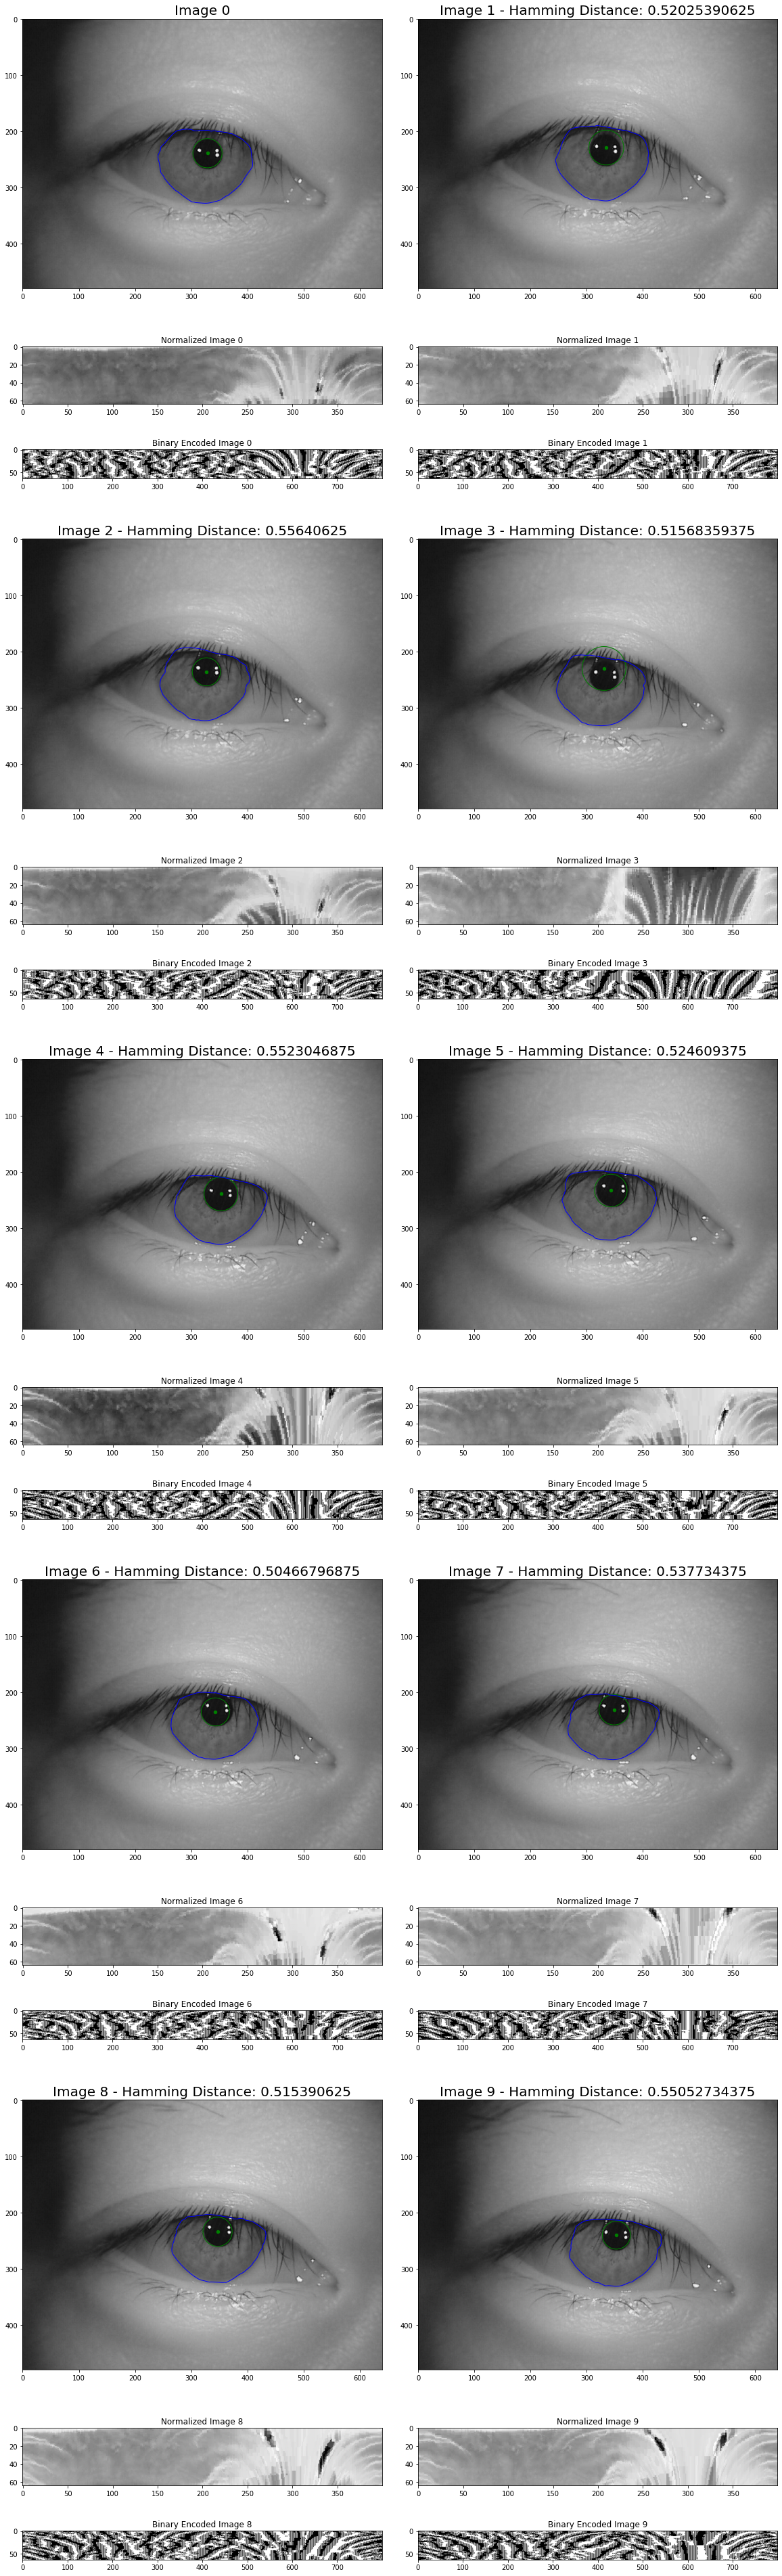

In [22]:
# plot_prepro(img_num1=0, img_num2=60, plot_cols=2)
plot_matching(img_num=0)